In [60]:
import pandas as pd
import numpy as np
import umap
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
pd.set_option('display.max_colwidth',None)

## embedding model

In [61]:
sentence_model = SentenceTransformer("embaas/sentence-transformers-multilingual-e5-base")

## Data

In [62]:
vec=np.load('data/embeddings/embs_e5.ar.npy',  allow_pickle=True)
# vec=np.load('data/embeddings/embs_v3.ar.npy', allow_pickle=True)

In [63]:
vec.shape

(413761, 768)

In [64]:
texts=pd.read_csv('data/embeddings/embs_text_e5.csv')
# texts=pd.read_csv('data/embeddings/embs_text_v3.csv')
texts.shape

(413761, 1)

In [65]:
texts_emb=dict()
for i, t in enumerate(texts.text_splitted.tolist()):
    texts_emb[t]=vec[i]

In [66]:
len(texts_emb)

413761

In [67]:
df_orig=pd.read_csv('data/raw/stenos_cleaned_faction2022_topics.csv')
df_orig.shape

(465494, 27)

In [68]:
df_orig.Name_red_outliers

0         273_kohaloleku_kontroll_arupärimisi_töönädala
1         1243_ettekanne_teostamisel_minutit_tegevusest
2          207_ettekanne_sõnavõttudega_minutit_vastused
3               139_ammendumiseni_pikendada_kauem_kella
4                 1461_maksude_maksud_maksudega_mängita
                              ...                      
465489                91_jõuluvana_aplaus_naer_luuletus
465490                91_jõuluvana_aplaus_naer_luuletus
465491                91_jõuluvana_aplaus_naer_luuletus
465492                                   -1_ma_te_me_et
465493                91_jõuluvana_aplaus_naer_luuletus
Name: Name_red_outliers, Length: 465494, dtype: object

In [69]:
df_orig[~df_orig.fation.isnull()].shape

(232059, 27)

In [70]:
df_orig.fation.value_counts()

Eesti Reformierakonna fraktsioon                    50485
Eesti Keskerakonna fraktsioon                       48313
Eesti Konservatiivse Rahvaerakonna fraktsioon       37919
Sotsiaaldemokraatliku Erakonna fraktsioon           31078
Isamaa fraktsioon                                   23842
Isamaa ja Res Publica Liidu fraktsioon              12894
Eesti Vabaerakonna fraktsioon                       11268
Fraktsiooni mittekuuluvad saadikud                   7935
Fraktsioonidesse mittekuulunud Riigikogu liikmed     5618
Erakonna Eestimaa Rohelised fraktsioon               1362
Eestimaa Rahvaliidu fraktsioon                       1050
Eesti 200 fraktsioon                                  295
Name: fation, dtype: int64

## Keep some faction texts

In [71]:
factions2keep=['Eesti Reformierakonna fraktsioon','Eesti Keskerakonna fraktsioon',
               'Eesti Konservatiivse Rahvaerakonna fraktsioon','Sotsiaaldemokraatliku Erakonna fraktsioon',
               'Isamaa fraktsioon', 'Isamaa ja Res Publica Liidu fraktsioon', 'Eesti Vabaerakonna fraktsioon',
              'Erakonna Eestimaa Rohelised fraktsioon', 'Eestimaa Rahvaliidu fraktsioon',
              'Eesti 200 fraktsioon', 'Fraktsiooni mittekuuluvad saadikud',
              'Fraktsioonidesse mittekuulunud Riigikogu liikmed']

df_orig_faction=df_orig[df_orig.fation.isin(factions2keep)]
df_orig_faction.shape

(232059, 27)

## Calculate attention

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Example class for attention-based aggregation of text embeddings
class AttentionAggregator(nn.Module):
    def __init__(self, embedding_dim):
        super(AttentionAggregator, self).__init__()
        # Define a linear layer for computing attention scores
        self.attention_layer = nn.Linear(embedding_dim, 1)
        
    def forward(self, embeddings):
        """
        embeddings: Tensor of shape (n_texts, embedding_dim)
        This represents the text embeddings for a single speaker.
        """
        # Compute attention scores
        attention_scores = self.attention_layer(embeddings)  # Shape: (n_texts, 1)
        attention_scores = attention_scores.squeeze(1)  # Shape: (n_texts)
        
        # Apply softmax to get normalized attention weights
        attention_weights = F.softmax(attention_scores, dim=0)  # Shape: (n_texts)
        
        # Compute the weighted sum of the embeddings
        weighted_embeddings = embeddings * attention_weights.unsqueeze(1)  # Shape: (n_texts, embedding_dim)
        speaker_embedding = torch.sum(weighted_embeddings, dim=0)  # Shape: (embedding_dim)
        
        return speaker_embedding, attention_weights

In [73]:
len(vec[0])

768

In [74]:
faction_emb=dict()
faction_weights=dict()
faction_texts=dict()
#embedding_dim = vec.shape[-1]
embedding_dim = len(vec[0])
faction_topics=dict()

for faction  in factions2keep:
    print(faction)
    df_fac_=df_orig_faction[df_orig_faction.fation==faction]
    texts_=df_fac_.text_splitted.tolist()
    faction_topics[faction]=df_fac_.Name_red_outliers.tolist()
    faction_texts[faction]=texts_.copy()
    print(f'no of texts {len(texts_)}')
    # texts_ids_ = texts[texts['text_splitted'].isin(texts_)].index
    # text_embeddings=torch.tensor(vec[texts_ids_])
    text_embeddings=torch.tensor(np.array([texts_emb[t] for t in texts_ if t in texts_emb]))

    # Create the attention aggregator model
    aggregator = AttentionAggregator(embedding_dim)

    # Aggregate the embeddings using the attention mechanism
    faction_embedding, attention_weights = aggregator(text_embeddings.to(torch.float32))
    faction_emb[faction]=faction_embedding
    faction_weights[faction]=attention_weights

Eesti Reformierakonna fraktsioon
no of texts 50485
Eesti Keskerakonna fraktsioon
no of texts 48313
Eesti Konservatiivse Rahvaerakonna fraktsioon
no of texts 37919
Sotsiaaldemokraatliku Erakonna fraktsioon
no of texts 31078
Isamaa fraktsioon
no of texts 23842
Isamaa ja Res Publica Liidu fraktsioon
no of texts 12894
Eesti Vabaerakonna fraktsioon
no of texts 11268
Erakonna Eestimaa Rohelised fraktsioon
no of texts 1362
Eestimaa Rahvaliidu fraktsioon
no of texts 1050
Eesti 200 fraktsioon
no of texts 295
Fraktsiooni mittekuuluvad saadikud
no of texts 7935
Fraktsioonidesse mittekuulunud Riigikogu liikmed
no of texts 5618


In [75]:
text_embeddings.dtype

torch.float32

In [76]:
aggregator.attention_layer.weight.dtype

torch.float32

In [77]:
text_embeddings.to(torch.float64).dtype

torch.float64

## plot vectors

In [78]:
faction_emb_ar=np.vstack([faction_emb[faction].detach().numpy() for faction in factions2keep])
# Reduce dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_reducer.fit_transform(faction_emb_ar)

/home/risto/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/risto/.local/lib/python3.9/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [79]:
faction_emb_ar.shape

(12, 768)

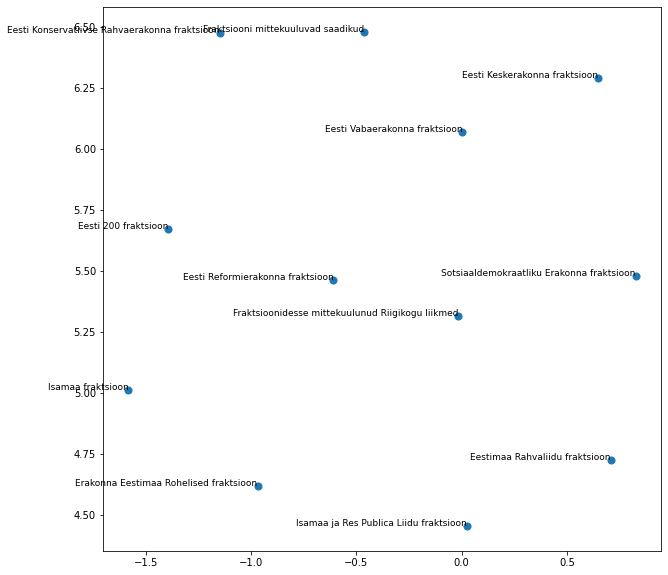

In [80]:
# Plot UMAP-reduced data with clusters
fig, ax=plt.subplots(figsize=(10,10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=50)
# Adding labels to each point
for i, label in enumerate(factions2keep):
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label, fontsize=9, ha='right')

plt.show()
plt.show()

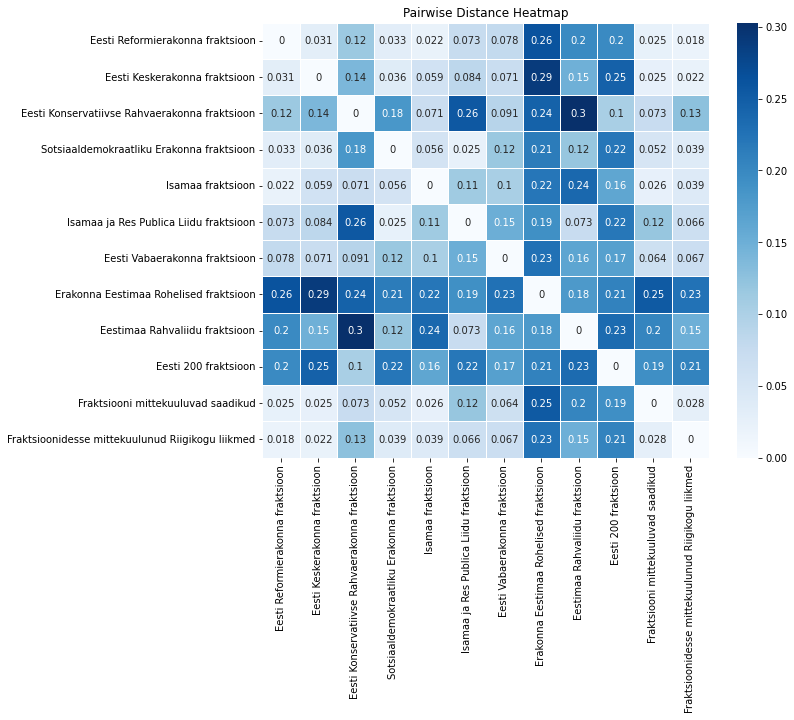

In [81]:
def calc_pairwise_dist(emb_ar, factions2keep):
    distance_matrix = pd.DataFrame(squareform(pdist(emb_ar, metric='cosine')))
    distance_matrix.columns=factions2keep
    distance_matrix.index=factions2keep
    return distance_matrix

def plot_pairwise_distances(emb_ar, factions2keep):
    distance_matrix=calc_pairwise_dist(emb_ar, factions2keep)

    # Step 3: Plot the Distance Matrix as a Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, annot=True, cmap='Blues', linewidths=0.5)
    plt.title('Pairwise Distance Heatmap')
    plt.show()

# # Step 2: Calculate Pairwise Euclidean Distances
distance_matrix = pd.DataFrame(squareform(pdist(faction_emb_ar, metric='cosine')))
distance_matrix.columns=factions2keep
distance_matrix.index=factions2keep

# # Step 3: Plot the Distance Matrix as a Heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(distance_matrix, annot=True, cmap='Blues', linewidths=0.5)
# plt.title('Pairwise Distance Heatmap')
# plt.show()

plot_pairwise_distances(distance_matrix, factions2keep)

## Semantic axes

In [82]:
# Step 2: Define the contrasting terms for the axis (e.g., Left vs. Right political axis)
left_concepts = [#"equality", "social justice", "workers' rights", "võrdsus", 
    "sotsiaalne õiglus", 
    "töötajate õigused", 
    "heaoluriik", 
    "avalik tervishoid", 
    "progressiivne maksustamine",
    "taskukohane eluaseme",
    "keskkonnakaitse",
    "LGBTQ+ õigused",
    "avaliku sektori investeeringud"]
right_concepts = [#"freedom", "individual responsibility", "free market",
                  "vabadus", 
    "individuaalne vastutus", 
    "vabaturg", 
    "rahvuslik suveräänsus", 
    "madalamad maksud", 
    "era tervishoid", 
    "traditsioonilised väärtused", 
    "karm sisserändepoliitika", 
    "tugev sõjavägi",
    "majanduskasv"]

# Step 3: Compute the embeddings for the contrasting terms
left_embeddings = sentence_model.encode(left_concepts)
right_embeddings = sentence_model.encode(right_concepts)

# Step 4: Calculate the semantic axis as the average difference between the left and right concepts
semantic_axis = np.mean(left_embeddings, axis=0) - np.mean(right_embeddings, axis=0)

# Step 5: Function to project new texts onto the semantic axis
def project_onto_axis(text_embedding, axis):
    return np.dot(text_embedding, axis) / np.linalg.norm(axis)

# Step 6: Test the semantic axis by projecting new texts onto it
texts = [
    "The government should ensure social welfare programs.",
    "Free markets create prosperity and opportunity for all.",
    "We need to protect workers' rights.",
    "Individual responsibility is key to success."
]

# Step 7: Get embeddings for the test texts
text_embeddings = sentence_model.encode(texts)

# Step 8: Project each text onto the semantic axis
for i, text_embedding in enumerate(text_embeddings):
    projection = project_onto_axis(text_embedding, semantic_axis)
    print(f"Text {i + 1}: '{texts[i]}' -> Projection on axis: {projection:.4f}")

Text 1: 'The government should ensure social welfare programs.' -> Projection on axis: 0.0624
Text 2: 'Free markets create prosperity and opportunity for all.' -> Projection on axis: 0.0640
Text 3: 'We need to protect workers' rights.' -> Projection on axis: 0.0850
Text 4: 'Individual responsibility is key to success.' -> Projection on axis: -0.0038


In [83]:
# Step 8: Project each text onto the semantic axis
for i, fac_embedding in enumerate(faction_emb_ar):
    projection = project_onto_axis(fac_embedding, semantic_axis)
    print(f"Faction  {factions2keep[i]} -> Projection on axis: {projection:.4f}")

Faction  Eesti Reformierakonna fraktsioon -> Projection on axis: 0.0704
Faction  Eesti Keskerakonna fraktsioon -> Projection on axis: 0.0704
Faction  Eesti Konservatiivse Rahvaerakonna fraktsioon -> Projection on axis: 0.0591
Faction  Sotsiaaldemokraatliku Erakonna fraktsioon -> Projection on axis: 0.0740
Faction  Isamaa fraktsioon -> Projection on axis: 0.0685
Faction  Isamaa ja Res Publica Liidu fraktsioon -> Projection on axis: 0.0743
Faction  Eesti Vabaerakonna fraktsioon -> Projection on axis: 0.0658
Faction  Erakonna Eestimaa Rohelised fraktsioon -> Projection on axis: 0.0754
Faction  Eestimaa Rahvaliidu fraktsioon -> Projection on axis: 0.0728
Faction  Eesti 200 fraktsioon -> Projection on axis: 0.0622
Faction  Fraktsiooni mittekuuluvad saadikud -> Projection on axis: 0.0698
Faction  Fraktsioonidesse mittekuulunud Riigikogu liikmed -> Projection on axis: 0.0701
